# Detection v2 model in caffe

----

# KB for pytorch and caffe

## Jupyter notebook KB

### turn off the specific cell
* [Ipython Notebook: Elegant way of turning off part of cells?
](https://stackoverflow.com/questions/34192290/ipython-notebook-elegant-way-of-turning-off-part-of-cells/56247673)

> `ESC` and `r` make teh raw cell
>
> `ESC` and `y` : code cell
>
> `ESC` and `m` : mark down cell


----

## Caffe KB


### how to extract network and layer parameter in caffe

* [Christopher tutorial](http://echo.etri.re.kr:8090/display/~kimkk/Christopher+Bourez%27s+Tutorial)

Create a first file `conv.prototxt` describing the neuron network :
```java
name: "convolution"
input: "data"
input_dim: 1
input_dim: 1
input_dim: 100
input_dim: 100
layer {
  name: "conv"
  type: "Convolution"
  bottom: "data"
  top: "conv"
  convolution_param {
    num_output: 3
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}

```
with one layer, a convolution, from the [Catalog of available layers](http://caffe.berkeleyvision.org/tutorial/layers.html)

load the net
```python
net = caffe.Net('conv.prototxt', caffe.TEST)
```



----

### accesing layer output and layer parameter

The names of input layers of the `net` are given by print **net.inputs**. 

The `net` contains two ordered dictionaries: 
* **net.blobs** : ordered dictionary with layer name as key, its value is `output` of the layer
* **net.params**: ordered dictionary with layer name as key, its value is `[weights, bias]`



----

### Layer output info: `net.blobs`

**net.blobs** for input data and its propagation in the layers
> `net.blobs['data']` contains input data, an array of shape (1, 1, 100, 100)   
> `net.blobs['conv']` contains computed data in layer ‘conv’ of shape (1, 3, 96, 96) initialiazed with zeros.

`net.blobs` ordererd dictionary contains input data and output of layer

To print the infos, 
```python
[(k, v.data.shape) for k, v in net.blobs.items()]
```
**Blobs** are memory abstraction objects (with execution depending on the mode), and data is contained in the field `data` as an array :
```python
print net.blobs['conv'].data.shape

```

----

### Layer prameter info: `net.params`

* **net.params** a vector of blobs for weight and bias parameters
> `net.params['conv'][0]` contains the weight parameters, an array of shape (3, 1, 5, 5) 
> `net.params['conv'][1]` contains the bias parameters, an array of shape (3,)
> * weight and bias are initialiazed with ‘weight_filler’ and ‘bias_filler’ algorithms.

To print the infos : 
```python
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]
```




----

# pytorch 및 mask_rcnn 관련 import 

In [1]:
import os
import argparse
from pprint import pprint
from glob import glob
from tqdm import tqdm

from PIL import Image, ImageDraw

import torch
from torchviz import make_dot
from torchvision import models
from pprint import pprint

import numpy as np

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data.transforms import build_transforms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.bounding_box import BoxList
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.label_catalog import LabelCatalog
from maskrcnn_benchmark.utils.converter import Converter


# caffe glog 로깅 레벨 설정 및 caffe 및 tools 관련 import

In [2]:
os.environ['GLOG_minloglevel'] = '3'

# import caffe and tools

In [3]:
import caffe
import tools.solvers
import tools.lmdb_io
import tools.prototxt
import tools.pre_processing

-----

# Detection V2 Model in PyTorch

## Detection Model Demo class

In [4]:
class DetectionDemo(object):
    #--------------------------------
    # __init__(cfg, weight, is_recognition=False)
    #--------------------------------
    def __init__(self, cfg, weight, is_recognition=False):
        self.is_recognition = is_recognition
        self.cfg = cfg.clone()
        self.device = torch.device(cfg.MODEL.DEVICE)
        #self.device = torch.device("cpu")
        self.model =  build_detection_model(self.cfg)
        self.model.to(self.device)

        # set to evaluation mode for interference
        self.model.eval()

        checkpointer = DetectronCheckpointer(cfg, self.model, save_dir='/dev/null')
        _ = checkpointer.load(weight)

        # build_transforms defined in maskrcnn_benchmark.data.transforms/*.py
        self.transforms = build_transforms(self.cfg, self.is_recognition)
        self.cpu_device = torch.device("cpu")
        self.score_thresh = self.cfg.TEST.SCORE_THRESHOLD
        
    #--------------------------------
    # run_on_pil(image_origin)
    #--------------------------------
    def run_on_pil_image(self, image_origin):
        # pil_image defined in __main__
        prediction = self.compute_prediction(pil_image)
        prediction = self.filter_by_score(prediction)
        prediction = prediction.resize(image_origin.size)
        result = self.parse_result(prediction)
        return result


    #--------------------------------
    # compute_predicion(image)
    #--------------------------------
    def compute_prediction(self, image):

        image_tensor = self.transforms(image)

        image_list = to_image_list(image_tensor, self.cfg.DATALOADER.SIZE_DIVISIBILITY).to(self.device)

        torch.save(self.model, "./detection_model_v2.pth")
        torch.save(self.model.backbone, "./detection_model_v2_backbone.pth")
        torch.save(self.model.backbone.body, "./detection_model_v2_backbone_body.pth")
        torch.save(self.model.backbone.fpn, "./detection_model_v2_backbone_fpn.pth")

        with torch.no_grad():
            pred = self.model(image_list)
            pred = pred[0].to(self.cpu_device)

        """
        model_param_dict = dict(self.model.named_parameters())
        print("-"*80)

        for key, value in model_param_dict.items():
            print(key)
            print(value)
            print("-"*80)
        """

        # make_dot(self.model(image_list), params=model_param_dict).render(f"detection_model_{version}", format="png")
        # https: // github.com / szagoruyko / pytorchviz / blob / master / examples.ipynb
        """
        with torch.onnx.set_training(self.model.backbone, False):
            trace, _ = torch.jit._get_trace_graph(self.model, args(image_list))
        make_dot_from_trace(trace).render(f"detection_mode_{version}_structure", format="png")
        """
        return pred


    #--------------------------------
    # filter_by_score(predition)
    #--------------------------------
    def filter_by_score(self, prediction):
        filter_thres = prediction.get_field('scores') > self.score_thresh
        return prediction[filter_thres]

    #--------------------------------
    # parse_result(pred)
    #--------------------------------
    def parse_result(self, pred):
        bbox = pred.bbox.numpy().tolist()
        scores = pred.get_field('scores').numpy().tolist()
        #labels = pred.get_field('labels').numpy().tolist()
        return dict(
            bboxes=bbox,     # list of [x1, y1, x2, y2]
            #labels=labels,  # no interest on label
            scores=scores,
        )


# detection model conf and weidht file names
detect_model = {
        "v1" :
        {
            "config_file" : "config_det_v1_200723_001_180k.yaml",
            "weight_file" : "model_det_v1_200723_001_180k.pth"

        },
        "v2" :
        {
            "config_file" : "config_det_v2_200924_002_180k.yaml",
            "weight_file" : "model_det_v2_200924_002_180k.pth"
        }
}


In [5]:
version = "v2"

----

### Test image 설정

In [100]:
image_file_path = "./sample_images/detection/1594202471809.jpg"
#image_file_path = "./sample_images/videoframes/frame000007.png"


----

### Configuration and Weight 파일 설정

In [101]:
# set model conf file path and mode weight file path
# prefixed by ./model/[detection|recognition]
config_file = os.path.join('./model/detection', detect_model[version]["config_file"])
weight_file = os.path.join('./model/detection', detect_model[version]["weight_file"])

In [102]:
# print cfg file path and weight file path (DEBUG)
print(f"config file path: {config_file}")
print(f"weight file path: {weight_file}")

config file path: ./model/detection/config_det_v2_200924_002_180k.yaml
weight file path: ./model/detection/model_det_v2_200924_002_180k.pth


----
### Configuration 파라메터 확인

In [103]:
 # clone project level config and merge with experiment config
cfg = cfg.clone()
cfg.merge_from_file(config_file)

In [104]:
print(cfg)

DATALOADER:
  SIZE_DIVISIBILITY: 32
INPUT:
  FIXED_SIZE: (-1, -1)
  MAX_SIZE_TEST: 640
  MIN_SIZE_TEST: 480
  PIXEL_MEAN: [102.9801, 115.9465, 122.7717]
  PIXEL_STD: [1.0, 1.0, 1.0]
  RESIZE_MODE: keep_ratio
  TARGET_INTERPOLATION: bilinear
  TO_BGR255: True
  TO_N1P1: False
MODEL:
  BACKBONE:
    CONV_BODY: R-50-FPN-RETINANET
    FREEZE_CONV_BODY_AT: 2
  DEVICE: cuda
  FPN:
    USE_GN: False
    USE_RELU: False
  GROUP_NORM:
    DIM_PER_GP: -1
    EPSILON: 1e-05
    NUM_GROUPS: 32
  MASK_ON: False
  META_ARCHITECTURE: GeneralizedRCNN
  RECOGNITION: False
  RESNETS:
    BACKBONE_OUT_CHANNELS: 1024
    DEFORMABLE_GROUPS: 1
    NUM_GROUPS: 1
    RES2_OUT_CHANNELS: 256
    RES5_DILATION: 1
    STAGE_WITH_DCN: (False, False, False, False)
    STEM_FUNC: StemWithFixedBatchNorm
    STEM_OUT_CHANNELS: 64
    STRIDE_IN_1X1: True
    TRANS_FUNC: BottleneckWithFixedBatchNorm
    WIDTH_PER_GROUP: 64
    WITH_MODULATED_DCN: False
  RETINANET:
    ANCHOR_SIZES: (32, 64, 128, 256, 512)
    ANCHOR_ST

----

### Detection Model 오브젝트 생성

In [105]:
# Detection model object creation
demo = DetectionDemo(cfg, weight_file)

----

## Accessing with model object in PyTorch

모델 오브젝트인 demo를 사용하여 다음과 같이 model 및 model을 구성하는 `nn.Module` 서브 클래스들을 접근할 수 있다.
>  dot '.'을 입력하고 TAB을 눌러서 자동 확장으로 확인할 수 있다.
* demo.model
* demo.model.backbone
* demo.model.backbone.body
* demo.model.backbone.body.stem
* demo.model.backbone.body.stem.conv1.weigth
* demo.model.backbone.body.stem.conv1.bias




----

## detection v2 model 구조
먼저 detection model 구조는 다음과 같이 구성되어 있다.

* detection model : backbone + rpn (region proposal net)
  * backbone : body (resetnet50) + fpn
  * rpn

----

In [106]:
print(demo.model)

GeneralizedRCNN(
  (backbone): Sequential(
    (body): ResNet(
      (stem): StemWithFixedBatchNorm(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
      )
      (layer1): Sequential(
        (0): BottleneckWithFixedBatchNorm(
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
        )
        (1): BottleneckWithFixedBatchNorm(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): Fro

----
## PyToch로 작성한 네트워크 모델의 레이어 정보 확인하기

계층 구조별로 dot으로 구분하면서 레이어의 정보를 확인할 수 있다. 
아래의 예제는 `demo.model.backbone.body.stem.conv1` 레이어의 입력 파라메터를 확인하는 예이다.
> dot '.'을 입력하고 TAB을 눌러서 자동 확장으로 확인할 수 있다.

In [107]:
print(f"demo.model.backbone.body.stem.conv1: {demo.model.backbone.body.stem.conv1}")
print(f"demo.model.backbone.body.stem.conv1.in_channels: {demo.model.backbone.body.stem.conv1.in_channels}" )
print(f"demo.model.backbone.body.stem.conv1.out_channels: {demo.model.backbone.body.stem.conv1.out_channels}" )
print(f"demo.model.backbone.body.stem.conv1.kernel_size: {demo.model.backbone.body.stem.conv1.kernel_size}")
print(f"demo.model.backbone.body.stem.conv1.stride: {demo.model.backbone.body.stem.conv1.stride}")
print(f"demo.model.backbone.body.stem.conv1.padding: {demo.model.backbone.body.stem.conv1.padding}")
print(f"demo.model.backbone.body.stem.conv1.bias: {demo.model.backbone.body.stem.conv1.bias}")

demo.model.backbone.body.stem.conv1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
demo.model.backbone.body.stem.conv1.in_channels: 3
demo.model.backbone.body.stem.conv1.out_channels: 64
demo.model.backbone.body.stem.conv1.kernel_size: (7, 7)
demo.model.backbone.body.stem.conv1.stride: (2, 2)
demo.model.backbone.body.stem.conv1.padding: (3, 3)
demo.model.backbone.body.stem.conv1.bias: None


----

### model.backbone.body 구조

back.bone.body 네트워크는 기본적으로 ResNet50 기반의 네트워크이다. 특징적으로 [FronzenBatchNorm2()](https://github.com/facebookresearch/maskrcnn-benchmark/blob/57eec25b75144d9fb1a6857f32553e1574177daf/maskrcnn_benchmark/layers/batch_norm.py#L6)가 사용된다.

In [108]:
print(demo.model.backbone.body)

ResNet(
  (stem): StemWithFixedBatchNorm(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
  )
  (layer1): Sequential(
    (0): BottleneckWithFixedBatchNorm(
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): FrozenBatchNorm2d()
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d()
    )
    (1): BottleneckWithFixedBatchNorm(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchN

----

### model.backbone.fpn 구조

In [109]:
print(demo.model.backbone.fpn)

FPN(
  (fpn_inner2): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
  (fpn_layer2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_inner3): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
  (fpn_layer3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_inner4): Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1))
  (fpn_layer4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (top_blocks): LastLevelP6P7(
    (p6): Conv2d(2048, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (p7): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)


----

### rpn 구조

In [110]:
print(demo.model.rpn)

RetinaNetModule(
  (anchor_generator): AnchorGenerator(
    (cell_anchors): BufferList()
  )
  (head): RetinaNetHead(
    (cls_tower): Sequential(
      (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
    )
    (bbox_tower): Sequential(
      (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
    )
    (cls_logits): C

----

## prediction with test images

In [111]:
# open image file as PIL.Image with RGB
pil_image = Image.open(image_file_path).convert('RGB')
#pil_image = Image.open(image_file_path)

**Number of channels in pil (pillow) image**
* https://stackoverflow.com/questions/52962969/number-of-channels-in-pil-pillow-image

<class 'PIL.Image.Image'>
RGB
{'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
('R', 'G', 'B')


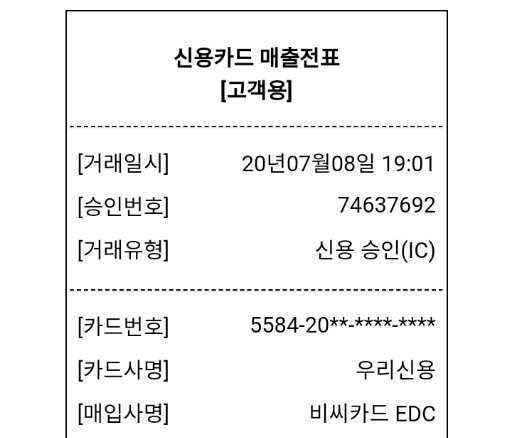

In [112]:
print(type(pil_image))
print(pil_image.mode)
print(pil_image.info)
print(pil_image.getbands())
display(pil_image)

In [113]:
org_pil_image = np.array(pil_image)
prediction = demo.run_on_pil_image(pil_image)

[<maskrcnn_benchmark.data.transforms.transforms.Resize object at 0x7fdeb1bf8278>, <maskrcnn_benchmark.data.transforms.transforms.ToTensor object at 0x7fdeb1bf82b0>, <maskrcnn_benchmark.data.transforms.transforms.Normalize object at 0x7fdeb1bf8eb8>]
images.image_sizes: [torch.Size([480, 561])]
images.tensors.shape: torch.Size([1, 3, 480, 576])


/home/kimkk/miniconda3/envs/lomin/lib/python3.6/site-packages/torch/jit/__init__.py:1044: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[0, 719, 27, 57] (0.06862227618694305 vs. 0.06861035525798798) and 1 other locations (0.00%)
  check_tolerance, _force_outplace, True, _module_class)


In [114]:
print(type(prediction))

<class 'dict'>


In [115]:
for key in prediction.keys():
    print(key)

bboxes
scores


In [116]:
print(prediction['bboxes'])

[[173.4861602783203, 45.561248779296875, 254.20643615722656, 68.81482696533203], [259.7876281738281, 46.130977630615234, 340.935791015625, 68.78086853027344], [218.3435821533203, 78.3564224243164, 291.47198486328125, 102.74018859863281], [78.97757720947266, 151.9032745361328, 168.05393981933594, 175.20535278320312], [241.73866271972656, 154.64248657226562, 290.1294250488281, 171.91529846191406], [330.268310546875, 153.10165405273438, 374.59375, 173.40774536132812], [389.616943359375, 154.3242645263672, 431.35400390625, 172.3855438232422], [338.6074523925781, 196.77133178710938, 389.1355895996094, 213.73782348632812], [388.91046142578125, 197.72410583496094, 435.09600830078125, 213.33485412597656], [79.02660369873047, 193.61044311523438, 168.49122619628906, 219.03070068359375], [315.4210510253906, 239.06263732910156, 354.816162109375, 260.6261901855469], [79.22467803955078, 238.76498413085938, 166.38702392578125, 261.3763732910156], [361.9833984375, 240.19735717773438, 430.4084777832031

In [117]:
print(len(prediction['bboxes']))

27


In [118]:
print(len(prediction['scores']))

27


In [119]:
bboxes = prediction['bboxes']
scores = prediction['scores']

In [120]:
def bb_image_draw(pil_image, line_color=(0, 0,255), line_width=4, score_threshold =0.5):
    pil_image_cp = pil_image.copy()  

    # for drawing bbox
    draw = ImageDraw.Draw(pil_image_cp)
    
    num_bbox_included = 0

    for idx, bbox in enumerate(bboxes):
        if scores[idx] > score_threshold:
            num_bbox_included += 1
            
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = round(x1), round(y1), round(x2), round(y2)
        
            draw.rectangle( ((x1,y1), (x2, y2)), outline=line_color, width=line_width)        
    
    return pil_image_cp, num_bbox_included
    
    

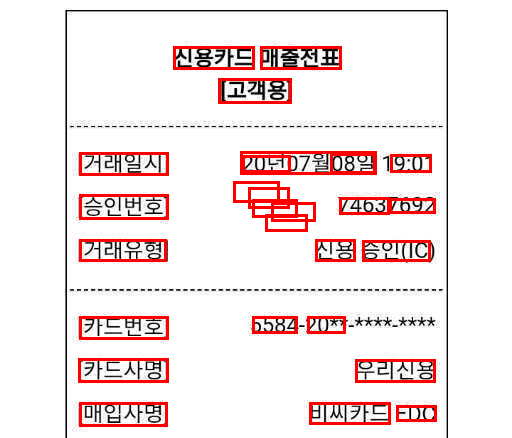

In [121]:
bboxed_image, num_boxes = bb_image_draw(pil_image, line_color=(255, 0, 0), line_width = 3, score_threshold = 0.3)
display(bboxed_image)

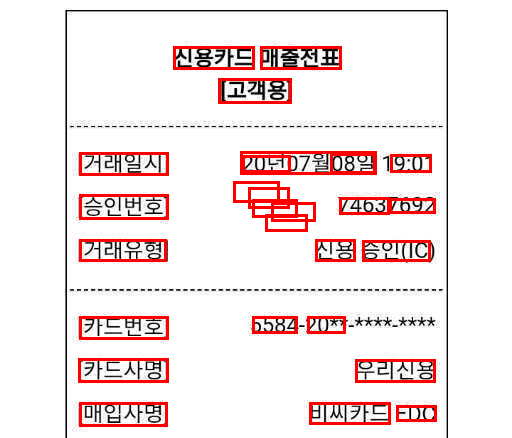

In [122]:
bboxed_image, num_boxes = bb_image_draw(pil_image, line_color=(255, 0, 0), line_width = 3, score_threshold = 0.4)
display(bboxed_image)

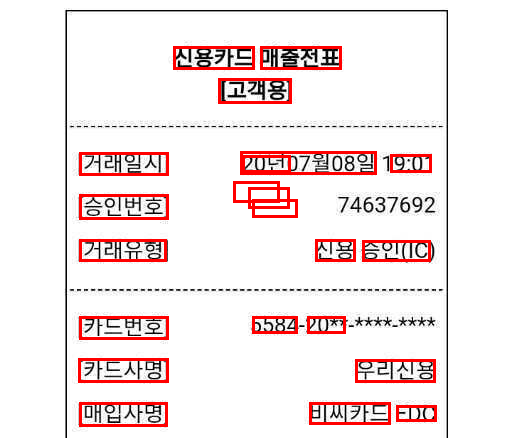

In [123]:
bboxed_image, num_boxes = bb_image_draw(pil_image, line_color=(255, 0, 0), line_width = 3, score_threshold = 0.5)
display(bboxed_image)

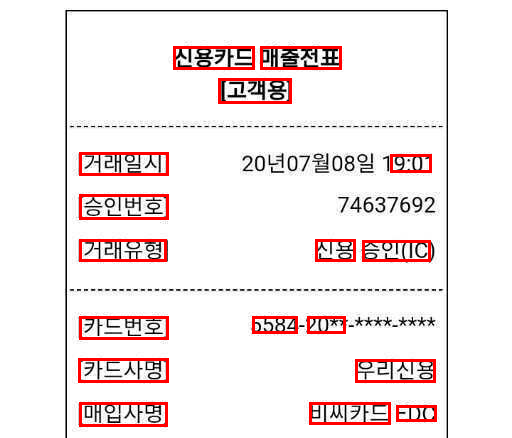

In [124]:
bboxed_image, num_boxes = bb_image_draw(pil_image, line_color=(255, 0, 0), line_width = 3, score_threshold = 0.7)
display(bboxed_image)

----

### Input Transform in PyTorch mask rcnn 

다음과 같은 PyTorch에서의 3개의 Transform을 순차적으로 적용한다.

* **resize**: [torchvision.transforms.functional.resize](https://pytorch.org/vision/master/transforms.html#torchvision.transforms.functional.resize)  
  > using `get_size()` with mode: keep_ratio, min_sizes = 480, max_size = 640 to determine resize dimension and call torchvision.transforms.functional.resize()  
  > `torchvision.transforms.functional.resize()` resize the input image to the given size. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions  

* **to_tensor**: [torchvision.transforms.functional.to_tensor](https://pytorch.org/vision/master/transforms.html#torchvision.transforms.functional.to_tensor)
  > Convert a PIL Image or numpy.ndarray to tensor. This function does not support torchscript.  

* **normalize**: [torchvision.transforms.Normalize](https://pytorch.org/vision/master/transforms.html#torchvision.transforms.Normalize)
  > Normalize a tensor image with mean and standard deviation. This transform does not support PIL Image. Given mean: (`mean[1],...,mean[n]`) and std: (`std[1],..,std[n]`) for `n` channels, 
  > this transform will normalize each channel of the input `torch.*Tensor` i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]

For example, input RGB 438 x 512 (h x w) PIL image will be transformed
* after resize: RGB 480 x 561 (h x w) PIL image
* after to_tensor: tensor of shape (3, 480, 561)
* after nomrmalize: 
    * convert from RGB to BGR format : `image = image[[2, 1, 0]] * 255`
    * subtract mean and divide std
    `mean: [102.9801, 115.9465, 122.7717], 
    `std: [1.0, 1.0, 1.0] after from RGB to BGR color channel conversion`

Caffe Equivalent 
* [caffe.io.Transformer example in programtalk.com](https://programtalk.com/python-examples/caffe.io.Transformer/)
* [caffe.io.load_image example in programtalk.com](https://programtalk.com/python-examples/caffe.io.load_image/)

```python

def create_transformer(self):
    """
    Create the input preprocessor and deprocessor using the default settings for
    the VGG-19 network.
    """
    # Give transformer necessary imput shape. Should be specified from
    # argparse arguments when creating the net
    transformer = caffe.io.Transformer(
        {'data': self.net.blobs['data'].data.shape}
    )
    # Order of the channels in the input data (not sure why necessary)
    transformer.set_transpose('data', (2, 0, 1))
    # Use BGR rather than RGB
    transformer.set_channel_swap('data', (2, 1, 0))
    # Subtract mean pixel
    transformer.set_mean('data', MEAN_PIXEL)
    # Use 8bit image values
    transformer.set_raw_scale('data', 255)
 
    return transformer
```



In [59]:
help(caffe.io.Transformer)

Help on class Transformer in module caffe.io:

class Transformer(builtins.object)
 |  Transform input for feeding into a Net.
 |  
 |  Note: this is mostly for illustrative purposes and it is likely better
 |  to define your own input preprocessing routine for your needs.
 |  
 |  Parameters
 |  ----------
 |  net : a Net for which the input should be prepared
 |  
 |  Methods defined here:
 |  
 |  __init__(self, inputs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  deprocess(self, in_, data)
 |      Invert Caffe formatting; see preprocess().
 |  
 |  preprocess(self, in_, data)
 |      Format input for Caffe:
 |      - convert to single
 |      - resize to input dimensions (preserving number of channels)
 |      - transpose dimensions to K x H x W
 |      - reorder channels (for instance color to BGR)
 |      - scale raw input (e.g. from [0, 1] to [0, 255] for ImageNet models)
 |      - subtract mean
 |      - scale feature
 |      
 |      Parameter

In [45]:
print(pil_image.size)
print(bboxed_image.size)

(512, 438)
(512, 438)


----

# Detection Model v2 in Caffe

In [82]:
def get_size(image, mode):
    # pytorch mask rcnn transforms.py get_size() replica
    
    """
    get suitable size for detection or recognition model
    """
    
    # get size of pil_image    
    w, h =  image.size
    #print(f"image size w: {w}, h:{h}")
    
    # output image width and height initialize
    ow, oh = -1, -1
    
    # i) recognition mdoel: 'horizontal_padding'
    if (mode=='horizontal_padding'):
        ow, oh = -1, -1
        target_width = int(w * (oh/h))
        if target_width < oh:
            target_width = oh
            
        if target_width > ow:
            target_width = ow
        
        ow = target_width
        
    # ii) detection model: 'keep_ratio'
    elif (mode == 'keep_ratio'):
        min_size = 480
        max_size = 640
        min_original_size = float(min((w,h)))
        max_original_size = float(max((w,h)))
        
        # summary
        # take smaller one from height or width, and resize smaller one to 480
        # and larger one is resized while keeping ratio

        # i) first determine max_size
        #   max_size : min_size  = max_original_size : min_original_size  -- (1)
        #       ? :  480  =  512 : 438
        # from (1) max_size = max_original_size * min_size / min_orignal_size
        #                   =  480*512/438 = 531.09 = 561
        # max size= 561.095     
        calc_max_size = max_original_size / min_original_size * min_size
        max_size = min(calc_max_size, max_size)
        # print(f"max_size: {max_size}")
        
        
        # ii) determine min_size from the determined max_size
        #   max_size : min_size  = max_original_size : min_original_size  -- (2)
        #      561.095  :  ?  =  512 : 438
        # from (2) min_size  =  max_size * min_original_size /  max_original_size
        #                    = 561.095 * 438 /512 = 479.99 = round(479.99) = 480
        min_size = round(max_size * min_original_size / max_original_size)
        # print(f"min_size: {min_size}")

        # if input image is a vertical image, i.e, height > width
        #   ow = min_size, oh = max_size
        # if input image is a horizontal image, i.e, width > height
        #   ow = max_size, oh = min_size
        ow = min_size if w < h else max_size

        oh = max_size if w < h else min_size

        # oh : 480, ow = 561.095
        # int() cause round off
        # oh : 480, ow = 561,
        # (438, 512)  => (480, 561)   ; keep ratio = 1.168
    return (int(oh), int(ow))


**OpenCV's resize method and bilinear interpolation**

* [OpenCV's resize method and bilinear interpolation](https://www.programmersought.com/article/3881684392/)
* [caffe ImageDataLayer](https://caffe.berkeleyvision.org/tutorial/layers/imagedata.html)
* [caffe resize image make all values 0](https://stackoverflow.com/questions/34611584/caffe-resize-image-make-all-values-0)

In [73]:
help(caffe.io.resize_image)

Help on function resize_image in module caffe.io:

resize_image(im, new_dims, interp_order=1)
    Resize an image array with interpolation.
    
    Parameters
    ----------
    im : (H x W x K) ndarray
    new_dims : (height, width) tuple of new dimensions.
    interp_order : interpolation order, default is linear.
    
    Returns
    -------
    im : resized ndarray with shape (new_dims[0], new_dims[1], K)



In [83]:
#image_file_path = "./sample_images/detection/1594202471809.jpg"
#image_file_path = "./sample_images/detection/1596537103856.jpeg"
image_file_path = "./sample_images/video_frames/frame000000.png"

In [84]:
pil_image = Image.open(image_file_path).convert('RGB')

In [85]:
new_size=get_size(pil_image, mode="keep_ratio")

 input image size w: 1280, h:720
max_size: 640
min_size: 360


In [81]:
print(new_size)  # tuple of (h, w) 

(360, 640)
